In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import rasterstats

ModuleNotFoundError: No module named 'numpy.distutils'

In [ ]:
import rasterstats

In [4]:
m_root=r"C:/Users/Liliana/OneDrive - Universidad Nacional de Colombia/1_Periodos_Asignaturas/Cursos_2024_2/2024_2_Programacion_SIG/Geocompy/"
m_root=r"/Users/macbook/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/1_Periodos_Asignaturas/Cursos_2024_2/2024_2_Programacion_SIG/Geocompy/"


src_srtm = rasterio.open(m_root+'data/srtm.tif')
src_nlcd = rasterio.open(m_root+'data/nlcd.tif')
src_grain = rasterio.open(m_root+'output/grain.tif')
src_elev = rasterio.open(m_root+'output/elev.tif')
src_dem = rasterio.open(m_root+'data/dem.tif')
zion = gpd.read_file(m_root+'data/zion.gpkg')
zion_points = gpd.read_file(m_root+'data/zion_points.gpkg')
cycle_hire_osm = gpd.read_file(m_root+'data/cycle_hire_osm.gpkg')
us_states = gpd.read_file(m_root+'data/us_states.gpkg')
nz = gpd.read_file(m_root+'data/nz.gpkg')
src_nz_elev = rasterio.open(m_root+'data/nz_elev.tif')

In [5]:
# Reproject zion to 
zion = zion.to_crs(src_srtm.crs)

# 1. Raster masking and cropping

Mask the src_strm so that all pixels that do not intersect the limits are no data

In [8]:

out_image_mask, out_transform_mask = rasterio.mask.mask(
    src_srtm, 
    zion.geometry, 
    crop=False, 
    nodata=9999
)

<span style="color:red;"><strong>🧠 What if you choose crop=True??    </strong></span>

In [11]:
out_image_mask

array([[[9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        ...,
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999]]], dtype=uint16)


Indicate that 999 means no data

In [16]:
dst_kwargs = src_srtm.meta
dst_kwargs.update(nodata=9999)
dst_kwargs

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 9999,
 'width': 465,
 'height': 457,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0008333333332777796, 0.0, -113.23958321278403,
        0.0, -0.0008333333332777843, 37.512916763165805)}

Write the masked raster to file with the updated metadata object.


In [19]:
new_dataset = rasterio.open(m_root+'output/srtm_masked.tif', 'w', **dst_kwargs)
new_dataset.write(out_image_mask)
new_dataset.close()

In [21]:
src_srtm_mask.meta

NameError: name 'src_srtm_mask' is not defined

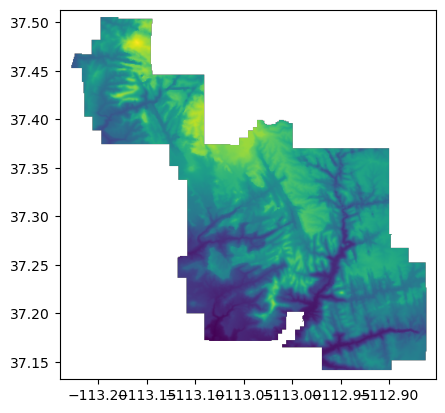

<Axes: >

In [23]:
# Remimport raster
src_srtm_mask = rasterio.open(m_root+'output/srtm_masked.tif')
rasterio.plot.show(src_srtm_mask)


<span style="color:red;"><strong>🧠 Whad does bb = zion.union_all().envelope do?   </strong></span>


# Raster Extraction

<span style="color:red;"><strong>🧠 What do you thnik raster extraction can be useful for? </strong></span>


Plot zion points ont op pf DEM

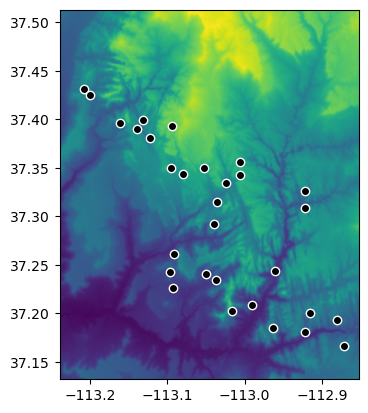

In [155]:
fig, ax = plt.subplots()
rasterio.plot.show(src_srtm, ax=ax)
zion_points.plot(ax=ax, color='black', edgecolor='white');

In [25]:
result1 = rasterstats.point_query(
    zion_points, 
    src_srtm.read(1), 
    nodata = src_srtm.nodata, 
    affine = src_srtm.transform,
    interpolate='nearest'
)

NameError: name 'rasterstats' is not defined

<span style="color:blue;"><strong>🧠 Another option</strong></span>


In [28]:
# Read raster data
raster_array = src_srtm.read(1)  # Read the first band as an array
nodata = src_srtm.nodata  # Get the NoData value from the raster

# Convert all point coordinates to raster matrix indices
rows, cols = np.array(src_srtm.index(zion_points.geometry.x, zion_points.geometry.y))  # Convert to NumPy arrays

# Create a mask to check if indices are within the raster bounds
valid_mask = (rows >= 0) & (rows < raster_array.shape[0]) & (cols >= 0) & (cols < raster_array.shape[1])

# Initialize an array with NoData values
values = np.full(len(zion_points), nodata)  # Fill with NoData by default

# Assign raster values to valid points
values[valid_mask] = raster_array[rows[valid_mask], cols[valid_mask]]

# Add extracted raster values to the GeoDataFrame
zion_points["raster_value"] = values

# Close the raster file
src_srtm.close()

# Print the final GeoDataFrame
print(zion_points)

                  geometry  raster_value
0     POINT (-112.92 37.2)        1802.0
1   POINT (-113.09 37.393)        2433.0
2   POINT (-113.02 37.335)        1886.0
3   POINT (-112.96 37.243)        1370.0
4   POINT (-112.99 37.208)        1452.0
5   POINT (-112.88 37.193)        1635.0
6   POINT (-113.05 37.241)        1380.0
7     POINT (-113.1 37.35)        2032.0
8   POINT (-113.04 37.314)        1830.0
9   POINT (-113.21 37.432)        1860.0
10  POINT (-112.92 37.181)        1440.0
11  POINT (-113.01 37.343)        2145.0
12  POINT (-112.92 37.326)        1942.0
13  POINT (-113.16 37.396)        1691.0
14  POINT (-112.87 37.166)        1776.0
15   POINT (-113.05 37.35)        2198.0
16  POINT (-112.96 37.185)        1820.0
17  POINT (-113.09 37.226)        1349.0
18   POINT (-113.2 37.425)        1758.0
19  POINT (-113.09 37.261)        1424.0
20  POINT (-113.01 37.356)        2159.0
21  POINT (-113.04 37.292)        1809.0
22  POINT (-113.12 37.381)        1826.0
23  POINT (-113.

<span style="color:blue;"><strong>🧠 Another option ... yees another one</strong></span>

Run this[ NOTEBOOK](https://github.com/remotesensinginfo/rsgislib-tutorials/blob/main/02_zonal_statistics/01_zonal_statistics_intro.ipynb) on your own data


# 2.  Rasterisation

<span style="color:orange;"><strong>  It is requiered the ‘template’ grid definition, i.e., the ‘template’ raster defining the extent, resolution and CRS of the output</strong></span>. 

Remember you "burn" numerical values


<span style="color:blue;"><strong>🧠 Buut... What is the right pixel size to rasterise your data? </strong></span>

<span style="color:plum;"><strong>🧠 Take a look at the following [Article](https://www.sciencedirect.com/science/article/abs/pii/S0098300405002657) </strong></span>


## 2.1. Rasterising points

First create a "template" raster with the same extent and CRS as the input vector data.
First transform the poind data into a ptojected CRS

In [64]:
cycle_hire_osm_projected = cycle_hire_osm.to_crs(27700)

In [66]:
# Get the bounding box (extent) of the vector dataset
bounds = cycle_hire_osm_projected.total_bounds
res = 1000
# Create an affine transformation for the raster (georeferencing information)
transform = rasterio.transform.from_origin(
    west=bounds[0],  # xmin (left/west boundary of the bounding box)
    north=bounds[3],  # ymax (top/north boundary of the bounding box)
    xsize=res,   # Pixel width (resolution in X direction)
    ysize=res  # you already know what this means
)
transform

Affine(1000.0, 0.0, 523037.00912759494,
       0.0, -1000.0, 184971.16277044098)

In [70]:
#To calculate the out_shape, we divide the x-axis and y-axis extent by the resolution, taking the ceiling of the results.

rows = math.ceil((bounds[3] - bounds[1]) / res)
cols = math.ceil((bounds[2] - bounds[0]) / res)
shape = (rows, cols)
shape

(11, 16)

<span style="color:blue;"><strong>🧠 Buut... We have not rasterised the points yet!! </strong></span>

### First approach: 
Raster represnenting presence/absense of cycle hire poins. 1=pixels where at lesst one point falls in

In [81]:
g = [(g, 1) for g in cycle_hire_osm_projected.geometry]
g[:5]


### Now we rsterise
ch_raster1 = rasterio.features.rasterize(
    shapes=g,
    out_shape=shape, 
    transform=transform
)
ch_raster1

array([[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

<span style="color:blue;"><strong>🧠 BTW... What are the parameters of rasterio.features.rasterize???? take a look at the documentation website [HERE](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html)  </strong></span>

### Second approach: 
Now you also cunt the number of bike hire stations. 

In [88]:
g = [(g, 1) for g in cycle_hire_osm_projected.geometry]
ch_raster2 = rasterio.features.rasterize(
    shapes=g,
    out_shape=shape,
    transform=transform,
    merge_alg=rasterio.enums.MergeAlg.add
)
ch_raster2

array([[ 0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  3,  3],
       [ 0,  0,  0,  1,  3,  3,  5,  5,  8,  9,  1,  3,  2,  6,  7,  0],
       [ 0,  0,  0,  8,  5,  4, 11, 10, 12,  9, 11,  4,  8,  5,  4,  0],
       [ 0,  1,  4, 10, 10, 11, 18, 16, 13, 12,  8,  6,  5,  2,  3,  0],
       [ 3,  3,  9,  3,  5, 14, 10, 15,  9,  9,  5,  8,  0,  0, 12,  2],
       [ 4,  5,  9, 11,  6,  7,  7,  3, 10,  9,  4,  0,  0,  0,  0,  0],
       [ 4,  0,  7,  8,  8,  4, 11, 10,  7,  3,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  3,  0,  0,  1,  4,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0,  1,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=uint8)